In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns 
import plotly.express as px
from sklearn.decomposition import PCA
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.cm as cm
from pathlib import Path


# Use the parent directory of this file for results
# results_dir = os.getcwd()
results_dir = "/net/trapnell/vol1/home/mdcolon/proj/morphseq/results/mcolon/20250923"
data_dir = os.path.join(results_dir, "data")
plot_dir = os.path.join(results_dir, "plots")

print(f"Results directory: {results_dir}")
os.makedirs(plot_dir, exist_ok=True)
os.makedirs(data_dir, exist_ok=True)


morphseq_root = os.environ.get('MORPHSEQ_REPO_ROOT')
morphseq_root = "/net/trapnell/vol1/home/mdcolon/proj/morphseq"
print(f"MORPHSEQ_REPO_ROOT: {morphseq_root}")
os.chdir(morphseq_root)

from scipy.interpolate import CubicSpline, interp1d


/net/trapnell/vol1/home/mdcolon/software/miniconda3/envs/vae_env_cluster/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Results directory: /net/trapnell/vol1/home/mdcolon/proj/morphseq/results/mcolon/20250923
MORPHSEQ_REPO_ROOT: /net/trapnell/vol1/home/mdcolon/proj/morphseq


In [2]:
combined_df = pd.read_csv("/net/trapnell/vol1/home/mdcolon/proj/morphseq/results/mcolon/20250920/data/tricane_tritraition_phenotype_analysis_input.csv")

combined_df.chem_n_genotype.value_counts()

/tmp/22952982.1.trapnell-short.q/ipykernel_1392151/2284024046.py:1: DtypeWarning: Columns (0,10,12,13,19,27,30,34,39,41,43,49,58,59,60,61,62,63,66,69,70,275) have mixed types. Specify dtype option on import or set low_memory=False.
  combined_df = pd.read_csv("/net/trapnell/vol1/home/mdcolon/proj/morphseq/results/mcolon/20250920/data/tricane_tritraition_phenotype_analysis_input.csv")


In [ ]:
# Use only z_mu_b columns and filter out bad rows by experiment
z_mu_cols = [col for col in combined_df.columns if col.startswith('z_mu_b_')]


Found 80 z_mu_b columns

NaN analysis by experiment:
20250912.0: 228 NaN rows out of 2291 total (10.0%)
20250711.0: 0 NaN rows out of 8330 total (0.0%)
nan: 0 NaN rows out of 0 total (nan%)



Overall: 228 NaN rows out of 16621 total
After cleaning: 16393 rows remaining

Remaining data by experiment:
20250912.0: 2063 rows
20250711.0: 8330 rows
nan: 0 rows


/tmp/22952982.1.trapnell-short.q/ipykernel_2245661/2874795450.py:10: RuntimeWarning: invalid value encountered in scalar divide
  print(f"{exp}: {rows_with_nan.sum()} NaN rows out of {len(exp_data)} total ({rows_with_nan.sum()/len(exp_data)*100:.1f}%)")


In [7]:
class LocalPrincipalCurve:
    def __init__(self, bandwidth=0.5, max_iter=100, tol=1e-4, angle_penalty_exp=2, h=None):

        from scipy.interpolate import CubicSpline, interp1d
        """
        Initialize the Local Principal Curve solver.
        """
        self.bandwidth = bandwidth
        self.h = h if h is not None else self.bandwidth
        self.max_iter = max_iter
        self.tol = tol
        self.angle_penalty_exp = angle_penalty_exp

        self.initializations = []
        self.paths = []
        self.cubic_splines_eq = []
        self.cubic_splines = []

    def _kernel_weights(self, dataset, x):
        dists = np.linalg.norm(dataset - x, axis=1)
        weights = np.exp(- (dists**2) / (2 * self.bandwidth**2))
        w = weights / np.sum(weights)
        return w

    def _local_center_of_mass(self, dataset, x):
        w = self._kernel_weights(dataset, x)
        mu = np.sum(dataset.T * w, axis=1)
        return mu

    def _local_covariance(self, dataset, x, mu):
        w = self._kernel_weights(dataset, x)
        centered = dataset - mu
        # cov = np.zeros((dataset.shape[1], dataset.shape[1]))
        weighted_centered = centered * w[:, np.newaxis]  # shape: (n, d)
        cov = np.dot(weighted_centered.T, centered)  # shape: (d, d)
        # for i in range(len(dataset)):
        #     cov += w[i] * np.outer(centered[i], centered[i])
        return cov

    def _principal_component(self, cov, prev_vec=None):
        vals, vecs = np.linalg.eig(cov)
        idx = np.argsort(vals)[::-1]
        # vals = vals[idx]
        vecs = vecs[:, idx]

        gamma = vecs[:, 0]  # first principal component

        # Sign/direction handling
        if prev_vec is not None and np.linalg.norm(prev_vec) != 0:
            cos_alpha = np.dot(gamma, prev_vec) / (np.linalg.norm(gamma)*np.linalg.norm(prev_vec))
            if cos_alpha < 0:
                gamma = -gamma

            # Angle penalization
            cos_alpha = np.dot(gamma, prev_vec) / (np.linalg.norm(gamma)*np.linalg.norm(prev_vec))
            a_x = (abs(cos_alpha))**self.angle_penalty_exp
            gamma = a_x * gamma + (1 - a_x) * prev_vec
            gamma /= np.linalg.norm(gamma)

        return gamma

    def _forward_run(self, dataset, x_start):
        x = x_start
        path_x = [x]
        prev_gamma = None

        for _ in range(self.max_iter):
            mu = self._local_center_of_mass(dataset, x)
            cov = self._local_covariance(dataset, x, mu)
            gamma = self._principal_component(cov, prev_vec=prev_gamma)

            x_new = mu + self.h * gamma

            if np.linalg.norm(mu - x) < self.tol:
                path_x.append(x_new)
                break

            path_x.append(x_new)
            x = x_new
            prev_gamma = gamma

        return np.array(path_x)

    def _backward_run(self, dataset, x0, gamma0):
        x = x0
        path_x = [x]
        prev_gamma = -gamma0

        for _ in range(self.max_iter):
            mu = self._local_center_of_mass(dataset, x)
            cov = self._local_covariance(dataset, x, mu)
            gamma = self._principal_component(cov, prev_vec=prev_gamma)

            x_new = mu + self.h * gamma
            if np.linalg.norm(mu - x) < self.tol:
                path_x.append(x_new)
                break

            path_x.append(x_new)
            x = x_new
            prev_gamma = gamma

        return np.array(path_x)

    def _find_starting_point(self, dataset, start_point):
        if start_point is None:
            idx = np.random.choice(len(dataset))
            return dataset[idx], idx
        else:
            diffs = dataset - start_point
            dists = np.linalg.norm(diffs, axis=1)
            min_idx = np.argmin(dists)
            closest_pt = dataset[min_idx]
            # if not np.allclose(closest_pt, start_point, rtol=1e-01):
            #     print(f"Starting point not in dataset. Using closest point: {closest_pt}")
            return closest_pt, min_idx

    def fit(self, dataset, start_points=None, end_point=None, num_points=500):
        """
        Fit LPC on the dataset. Optionally provide:
         - start_points: array of shape (d,) or a single point of shape (d,)
         - end_point: single point of shape (d,), only allowed if a start_point is provided.
        """
        dataset = np.array(dataset)
        self.paths = []
        self.initializations = []

        if end_point is not None and start_points is None:
            raise ValueError("end_point provided but no start_points given. end_point only allowed if start_point is provided.")

        # Ensure start_points is a list
        if start_points is not None and not isinstance(start_points, (list, tuple)):
            start_points = [start_points]

        if end_point is not None and (start_points is None or len(start_points) != 1):
            raise ValueError("If end_point is provided, exactly one start_point must be provided.")

        for sp in (start_points if start_points is not None else [None]):
            x0, _ = self._find_starting_point(dataset, sp)

            forward_path = self._forward_run(dataset, x0)
            if len(forward_path) > 1:
                initial_gamma_direction = (forward_path[1] - forward_path[0]) / self.h
            else:
                initial_gamma_direction = np.zeros(dataset.shape[1])
            # Debugging
            # import pdb
            # pdb.set_trace()
            # Debugging
            if np.linalg.norm(initial_gamma_direction) > 0:
                backward_path = self._backward_run(dataset, x0, initial_gamma_direction)
                full_path = np.vstack([backward_path[::-1], forward_path[1:]])
            else:
                full_path = forward_path

            # Check orientation
            dist_start_to_first = np.linalg.norm(x0 - full_path[0])
            dist_start_to_last = np.linalg.norm(x0 - full_path[-1])
            if dist_start_to_last < dist_start_to_first:
                full_path = full_path[::-1]

            self.paths.append(full_path)
            self.initializations.append(x0)

        # Fit splines and compute equal arc-length
        self._fit_cubic_splines_eq()
        self._compute_equal_arc_length_spline_points(num_points=num_points)

        # If end_point provided, correct for the looping back issue
        # if end_point is not None:
        #     try:
        #         # Assuming a single path scenario
        #         spline_points = self.cubic_splines[0]
        #
        #         # 1) Find closest point on cubic_spline to end_point
        #         dists = np.linalg.norm(spline_points - end_point, axis=1)
        #         closest_idx = np.argmin(dists)
        #
        #         # 2) Determine end_direction_vector using points around closest_idx
        #         # We'll take up to 3 points: [closest_idx-1, closest_idx, closest_idx+1]
        #         # If closest_idx is at the boundary, adjust accordingly
        #         if closest_idx == 0:
        #             # At start, use next two points if available
        #             if len(spline_points) > 2:
        #                 p0 = spline_points[closest_idx]
        #                 p1 = spline_points[closest_idx + 1]
        #                 p2 = spline_points[closest_idx + 2]
        #                 end_direction_vector = ((p1 - p0) + (p2 - p1)) / 2.0
        #             else:
        #                 # If very short, just fallback
        #                 end_direction_vector = np.array([1, 0, 0])
        #         elif closest_idx == len(spline_points) - 1:
        #             # At the end, we might not have a point after it
        #             # use the two points before it if possible
        #             if len(spline_points) > 2:
        #                 p_end = spline_points[closest_idx]
        #                 p_endm1 = spline_points[closest_idx - 1]
        #                 p_endm2 = spline_points[closest_idx - 2]
        #                 end_direction_vector = ((p_end - p_endm1) + (p_endm1 - p_endm2)) / 2.0
        #             else:
        #                 end_direction_vector = np.array([1, 0, 0])
        #         else:
        #             # Middle somewhere, use prev and next
        #             p_before = spline_points[closest_idx - 1]
        #             p_mid = spline_points[closest_idx]
        #             p_after = spline_points[closest_idx + 1]
        #             end_direction_vector = ((p_mid - p_before) + (p_after - p_mid)) / 2.0
        #
        #         # Normalize end_direction_vector
        #         norm_edv = np.linalg.norm(end_direction_vector)
        #         if norm_edv > 0:
        #             end_direction_vector = end_direction_vector / norm_edv
        #         else:
        #             warnings.warn("end_direction_vector has zero magnitude. Using default direction.")
        #             end_direction_vector = np.array([1, 0, 0])
        #
        #         # 3) Check directionality after closest_idx
        #         # We'll look at pairs of points (p_j, p_{j+1}) for j > closest_idx
        #         cutoff_index = None
        #         for j in range(closest_idx + 1, len(spline_points) - 1):
        #             seg_vec = spline_points[j + 1] - spline_points[j]
        #             csim = cosine_similarity(seg_vec.reshape(1, -1), end_direction_vector.reshape(1, -1))
        #             if csim < 0.5:
        #                 cutoff_index = j + 1
        #                 break
        #
        #         # If we found a cutoff_index, truncate the spline
        #         if cutoff_index is not None:
        #             spline_points = spline_points[:cutoff_index]
        #
        #             # Refit with truncated spline_points
        #             self.paths = [spline_points]
        #             self._fit_cubic_splines_eq()
        #             self._compute_equal_arc_length_spline_points()
        #
        #     except (ValueError, IndexError, TypeError) as e:
        #         # Log a warning and exit the if block gracefully
        #         warnings.warn(
        #             f"Error processing spline with end_point: {e}. Skipping spline adjustment."
        #         )
        #         # Optionally, you can log more details for debugging
        #         # For example:
        #         # warnings.warn(f"Error processing spline: {e}. spline_points shape: {spline_points.shape}, end_point shape: {np.shape(end_point)}")
        #         return  # Exit the if block

        return self.paths

    def _fit_cubic_splines_eq(self):
        self.cubic_splines_eq = []
        for path in self.paths:
            if len(path) < 4:
                self.cubic_splines_eq.append(None)
                continue
            t = np.arange(len(path))
            splines_dict = {}
            for dim in range(path.shape[1]):
                splines_dict[dim] = CubicSpline(t, path[:, dim])
            self.cubic_splines_eq.append(splines_dict)

    def _compute_cubic_spline_points(self, num_points=500):
        self.cubic_splines = []
        for i, eq in enumerate(self.cubic_splines_eq):
            if eq is None:
                self.cubic_splines.append(None)
                continue
            path = self.paths[i]
            t_values = np.linspace(0, len(path) - 1, num_points)
            spline_points = self.evaluate_cubic_spline(i, t_values)
            self.cubic_splines.append(spline_points)

    def evaluate_cubic_spline(self, path_idx, t_values):
        if path_idx >= len(self.cubic_splines_eq) or self.cubic_splines_eq[path_idx] is None:
            raise ValueError(f"No cubic spline found for path index {path_idx}.")
        spline = self.cubic_splines_eq[path_idx]
        points = np.array([spline[dim](t_values) for dim in sorted(spline.keys())]).T  # Fixed line
        return points

    def compute_arc_length(self, spline, t_min, t_max, num_samples=10000):
        t_values = np.linspace(t_min, t_max, num_samples)
        points = np.array([spline[dim](t_values) for dim in sorted(spline.keys())]).T  # Fixed line

        distances = np.sqrt(np.sum(np.diff(points, axis=0)**2, axis=1))
        cumulative_length = np.insert(np.cumsum(distances), 0, 0.0)
        return t_values, cumulative_length

    def get_uniformly_spaced_points(self, spline, num_points):
        path_length = len(spline[0].x)
        t_min = 0
        t_max = path_length - 1

        t_vals_dense, cum_length = self.compute_arc_length(spline, t_min, t_max, num_samples=5000)
        total_length = cum_length[-1]
        desired_distances = np.linspace(0, total_length, num_points)
        t_for_dist = interp1d(cum_length, t_vals_dense, kind='linear')(desired_distances)

        uniform_points = np.array([spline[dim](t_for_dist) for dim in sorted(spline.keys())]).T  # Fixed line
        return uniform_points

    def _compute_equal_arc_length_spline_points(self, num_points=500):
        self.cubic_splines = []
        for i, eq in enumerate(self.cubic_splines_eq):
            if eq is None:
                self.cubic_splines.append(None)
                continue
            spline_points = self.get_uniformly_spaced_points(eq, num_points)
            self.cubic_splines.append(spline_points)

    def plot_path_3d(self, path_idx=0, dataset=None):
        dataset = np.array(dataset)
        path = self.paths[path_idx]
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        if dataset is not None:
            ax.scatter(dataset[:,0], dataset[:,1], dataset[:,2], alpha=0.5, label='Data')
        ax.plot(path[:,0], path[:,1], path[:,2], 'r-', label='Local Principal Curve')
        ax.legend()
        plt.show()

    def plot_cubic_spline_3d(self, path_idx, show_path=True):
        if path_idx >= len(self.paths):
            raise IndexError(f"Path index {path_idx} is out of range. Total paths: {len(self.paths)}.")
        path = self.paths[path_idx]
        spline_points = self.cubic_splines[path_idx]
        fig = plt.figure()
        ax = fig.add_subplot(111, projection="3d")
        if show_path:
            ax.scatter(path[:, 0], path[:, 1], path[:, 2], label="LPC Path", alpha=0.5)
        ax.plot(spline_points[:, 0], spline_points[:, 1], spline_points[:, 2], color="red", label="Cubic Spline")
        ax.legend()
        plt.show()

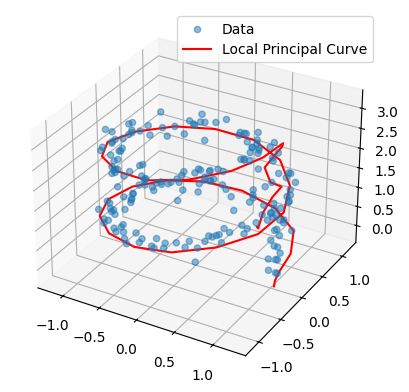

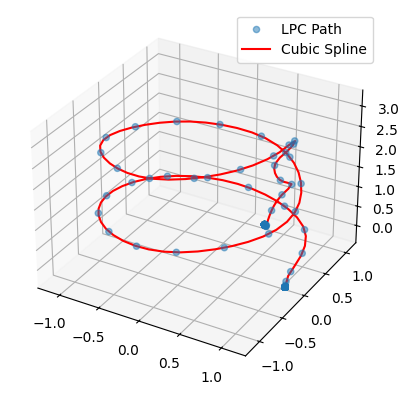

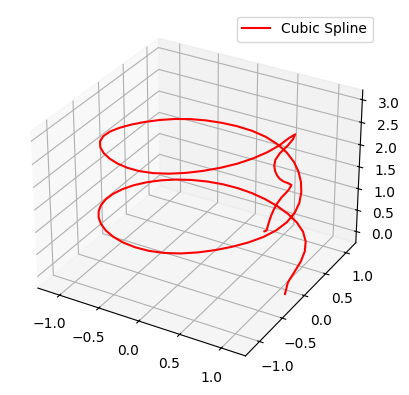

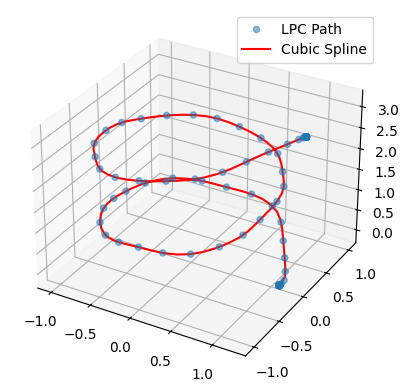

In [12]:
# BARE MINIMUM USAGE
import numpy as np

# SLIGHTLY MORE REALISTIC EXAMPLE
# Generate some curved 3D data (like a helix)
t = np.linspace(0, 4*np.pi, 200)
data = np.column_stack([
    np.cos(t) + 0.1*np.random.randn(200),
    np.sin(t) + 0.1*np.random.randn(200), 
    t/4 + 0.1*np.random.randn(200)
])

# Fit curve with custom parameters
lpc = LocalPrincipalCurve(bandwidth=0.5, max_iter=100, tol=1e-4, angle_penalty_exp=2, h=None)  # Adjust smoothness
lpc.fit(data, num_points=100)  # Get 100 points on curve

# Access the results
curve = lpc.cubic_splines[0]

# That's it! curve now contains your fitted principal curve

# PLOTTING THE RESULTS
import matplotlib.pyplot as plt

# Method 1: Plot the raw LPC path with original data
lpc.plot_path_3d(path_idx=0, dataset=data)

# Method 2: Plot the smooth cubic spline curve
lpc.plot_cubic_spline_3d(path_idx=0, show_path=True)  # show_path=True shows both raw path and spline

# Method 3: Plot only the smooth spline (no raw path points)
lpc.plot_cubic_spline_3d(path_idx=0, show_path=False)

# COMPLETE MINIMAL EXAMPLE WITH PLOTTING
import numpy as np
import matplotlib.pyplot as plt

# Generate spiral data
t = np.linspace(0, 4*np.pi, 200)
data = np.column_stack([
    np.cos(t) + 0.1*np.random.randn(200),
    np.sin(t) + 0.1*np.random.randn(200), 
    t/4 + 0.1*np.random.randn(200)
])

# Fit and plot in one go
lpc = LocalPrincipalCurve(bandwidth=0.3)
lpc.fit(data, num_points=100)

# Show the results
lpc.plot_cubic_spline_3d(0)  # This will display an interactive 3D plot

In [13]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA

def add_pca_components(
    df: pd.DataFrame,
    prefix: str = "z_mu_b",
    n_components: int = 3,
) -> pd.DataFrame:
    """
    Detect columns starting with `prefix` (default: 'z_mu_b'), run PCA on them,
    and append PCA_1..PCA_k columns to the input DataFrame.

    Returns:
        The same DataFrame object with PCA_* columns added.
    """
    # 1) Detect biological columns
    bio_cols = [c for c in df.columns if c.startswith(prefix)]
    if not bio_cols:
        raise ValueError(f"No columns start with prefix '{prefix}'.")
    
    # 2) Extract matrix and validate
    X = df[bio_cols].to_numpy()
    if np.isnan(X).any():
        raise ValueError(
            "NaNs detected in biological columns. Please impute or drop before PCA."
        )

    # 3) Fit PCA (clip components to available features)
    k = min(n_components, X.shape[1])
    if k < 1:
        raise ValueError("Not enough features for PCA.")
    pca = PCA(n_components=k)
    pcs = pca.fit_transform(X)

    # 4) Append PCA columns
    pca_cols = [f"PCA_{i+1}" for i in range(k)]
    df.loc[:, pca_cols] = pcs

    return df

In [23]:
combined_df_pca["chem_n_genotype"].unique()

array(['tri_1-15_wik-ab', 'tri_1-20_wik-ab', 'tri_1-25_wik-ab',
       'tri_1-30_wik-ab', 'tri_1-35_wik-ab', 'tri_1-40_wik-ab',
       'tri_0_wik-ab', 'nan_tmem67_heterozygote', 'nan_tmem67_homozygous',
       'nan_tmem67_wildtype', 'nan_wik'], dtype=object)

Fitted LPC for genotype: tri_1-15_wik-ab


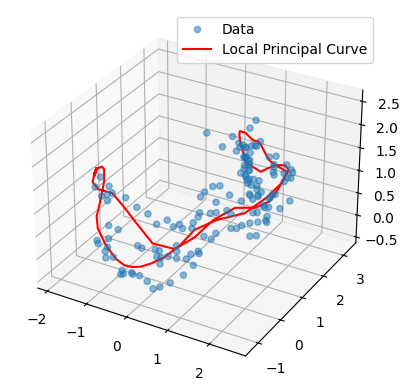

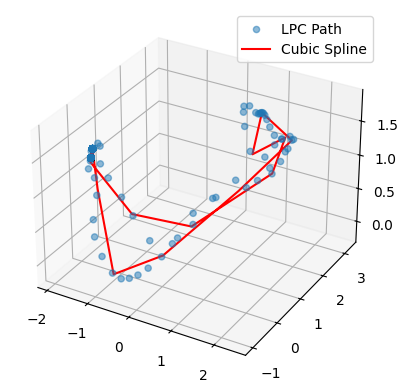

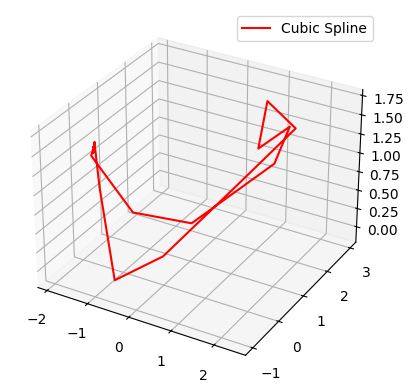

Fitted LPC for genotype: tri_1-20_wik-ab


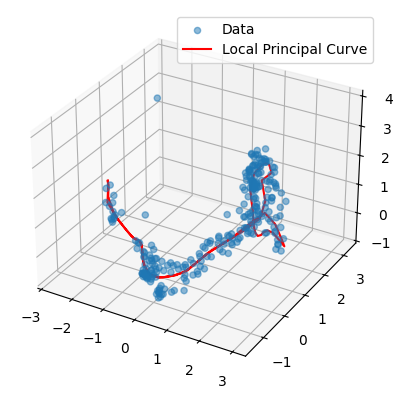

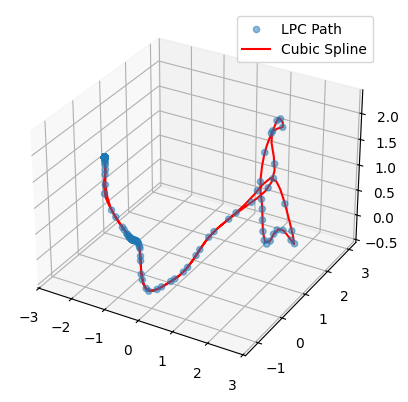

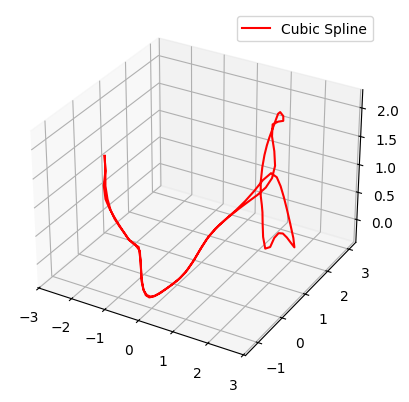

Fitted LPC for genotype: tri_1-25_wik-ab


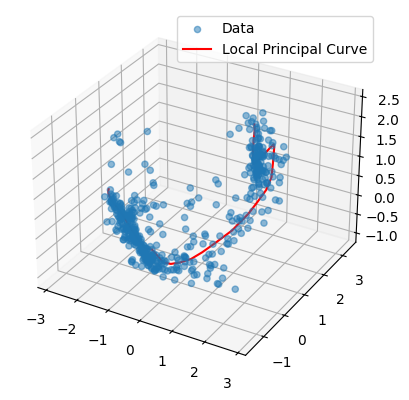

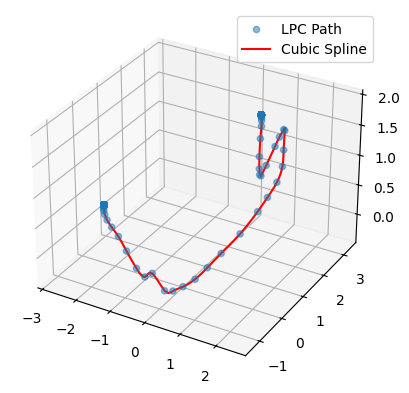

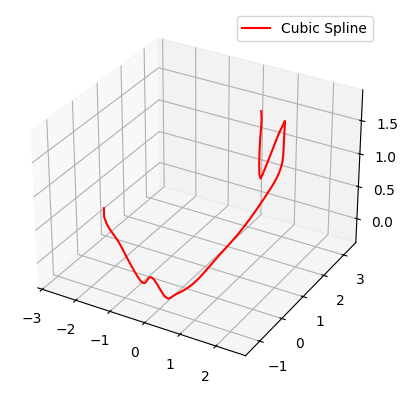

Fitted LPC for genotype: tri_1-30_wik-ab


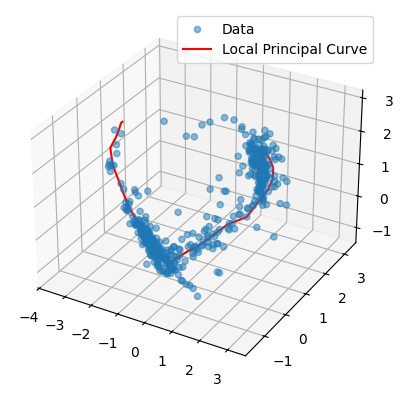

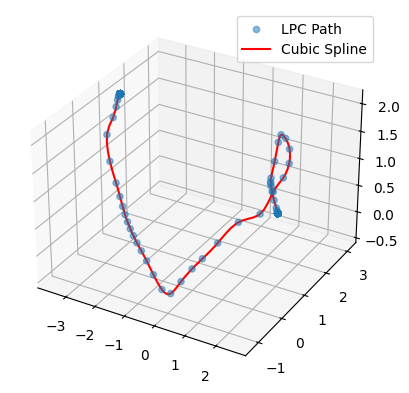

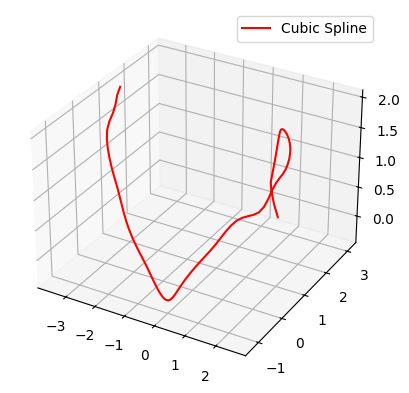

Fitted LPC for genotype: tri_1-35_wik-ab


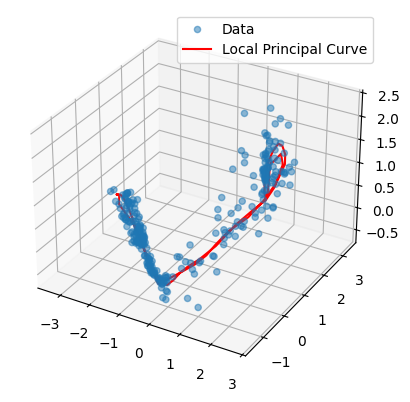

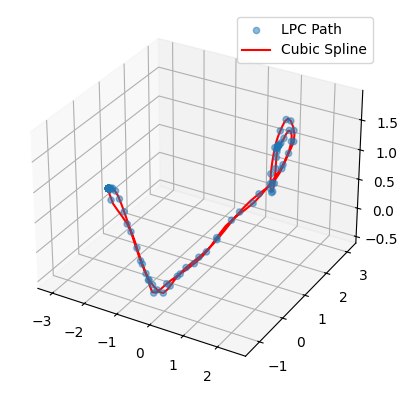

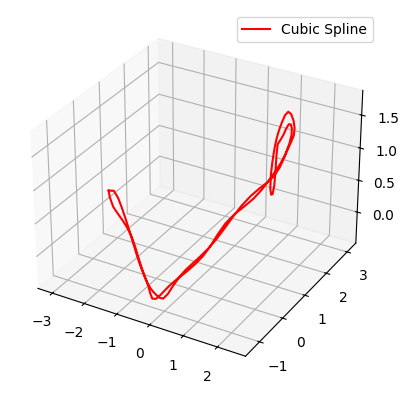

Fitted LPC for genotype: tri_1-40_wik-ab


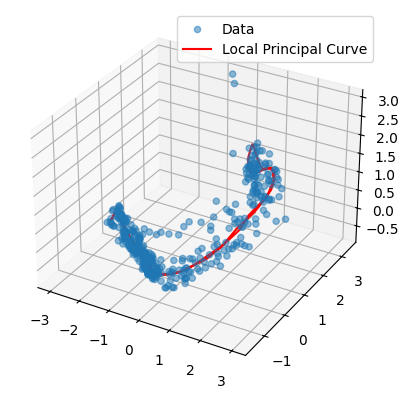

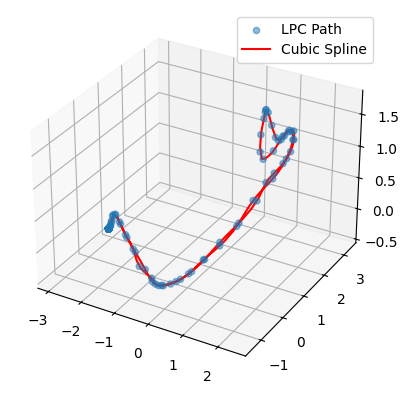

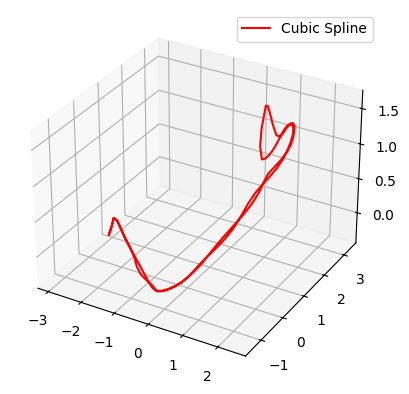

Fitted LPC for genotype: tri_0_wik-ab


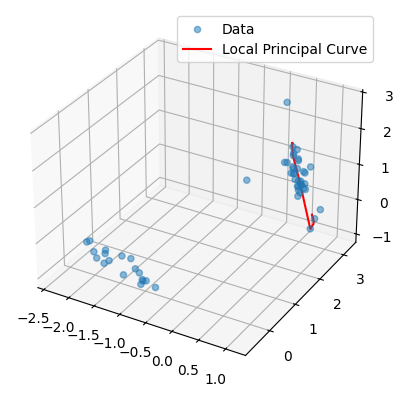

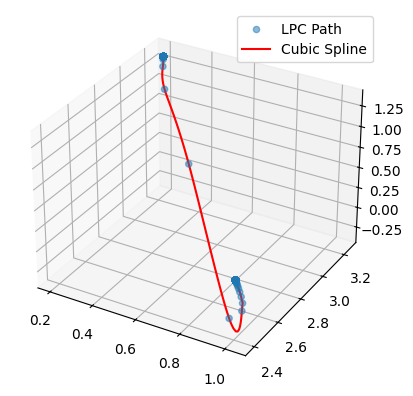

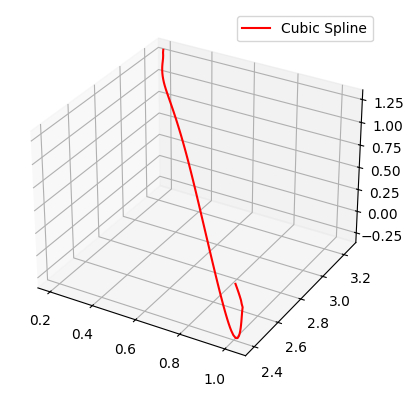

Fitted LPC for genotype: nan_tmem67_heterozygote


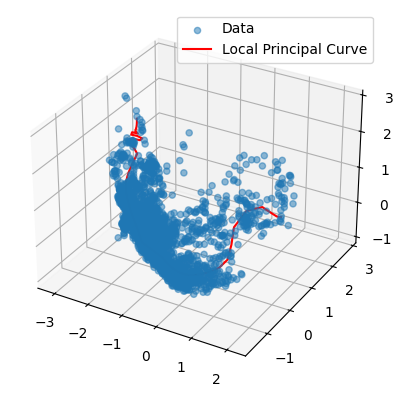

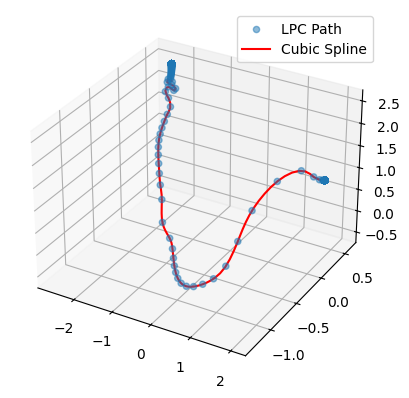

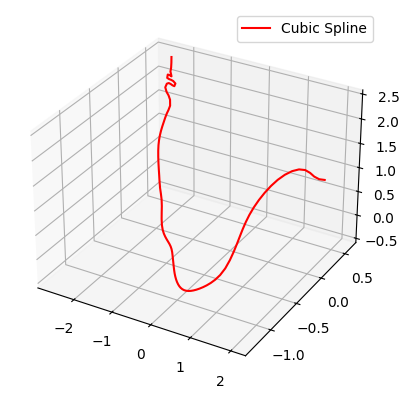

Fitted LPC for genotype: nan_tmem67_homozygous


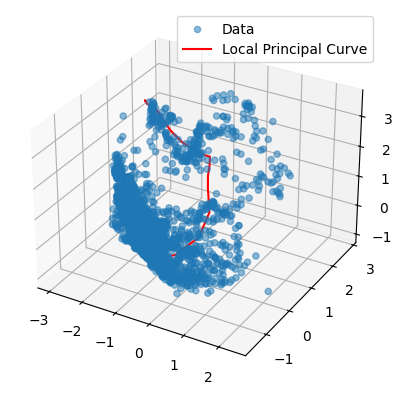

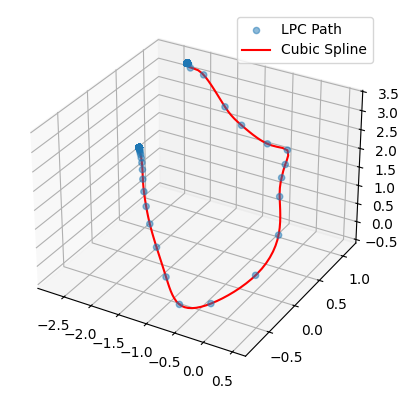

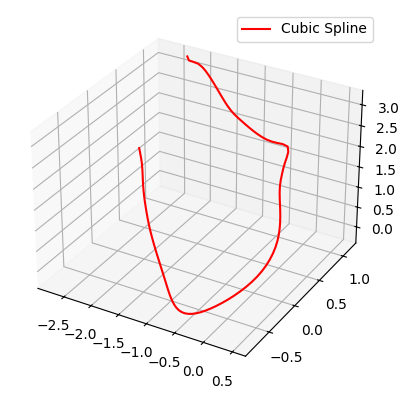

Fitted LPC for genotype: nan_tmem67_wildtype


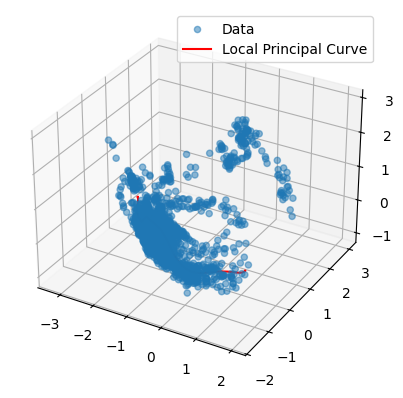

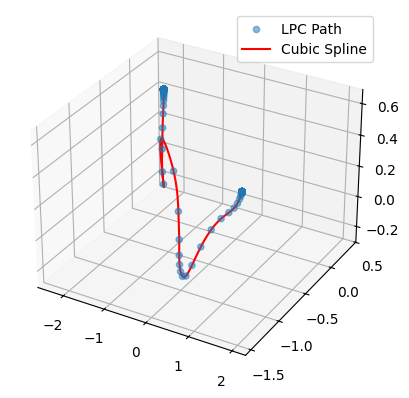

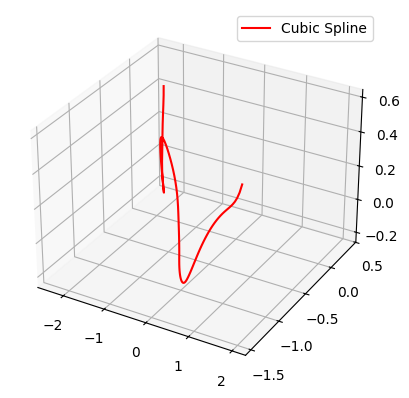

Fitted LPC for genotype: nan_wik


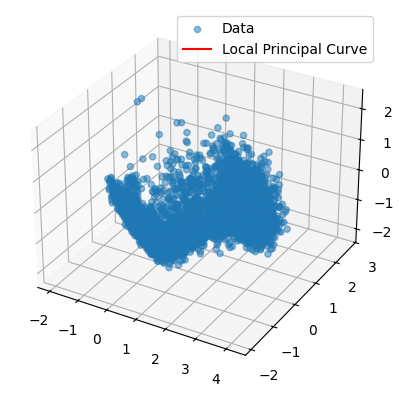

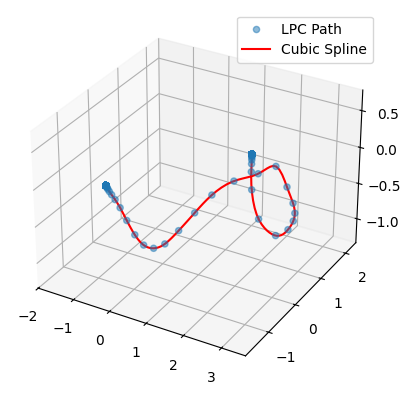

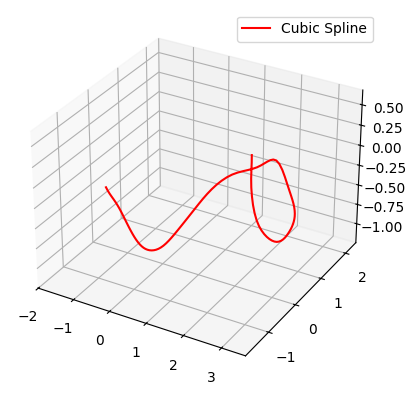

In [34]:
combined_df_pca = add_pca_components(combined_df, prefix="z_mu_b", n_components=3)

for genotype in combined_df_pca["chem_n_genotype"].unique():

    subset_to = combined_df_pca["chem_n_genotype"]==genotype

    pca_data = combined_df_pca.loc[subset_to, ["PCA_1", "PCA_2", "PCA_3"]]


    # Fit curve with custom parameters
    lpc = LocalPrincipalCurve(bandwidth=.5, max_iter=500, tol=1e-4, angle_penalty_exp=1, h=None)  # Adjust smoothness
    lpc.fit(pca_data, num_points=100)  # Get 100 points on curve

    print(f"Fitted LPC for genotype: {genotype}")

    # Access the results
    curve = lpc.cubic_splines[0]

    # That's it! curve now contains your fitted principal curve

    # PLOTTING THE RESULTS
    import matplotlib.pyplot as plt

    # Method 1: Plot the raw LPC path with original data
    lpc.plot_path_3d(path_idx=0, dataset=pca_data)

    # Method 2: Plot the smooth cubic spline curve
    lpc.plot_cubic_spline_3d(path_idx=0, show_path=True)  # show_path=True shows both raw path and spline

    # Method 3: Plot only the smooth spline (no raw path points)
    lpc.plot_cubic_spline_3d(path_idx=0, show_path=False)
